Universidad del Valle de Guatemala <br>
28/01/2022 <br>
Minería de Datos # 20 

# Hoja de Trabajo 2
## Clustering

**Integrantes:**<br>
Walter Saldaña 19897 <br>
José Gutierrez 19111 <br>
Javier Cotto 19324 <br>

Importar modulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Cargar la base de datos a pandas

In [2]:
datos = pd.read_csv('movies.csv', encoding='unicode_escape')
datos.head()

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,popularity,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
0,5,4000000,Crime|Comedy,https://www.miramax.com/movie/four-rooms/,Miramax|A Band Apart,US|US,United States of America,4257354.0,98,False,...,20.880,1995-12-09,5.7,2077,2,2,1,25,15,9
1,6,21000000,Action|Thriller|Crime,NaN,Universal Pictures|Largo Entertainment|JVC,US|US|JP,Japan|United States of America,12136938.0,110,False,...,9.596,1993-10-15,6.5,223,3,3,2,15,3,9
2,11,11000000,Adventure|Action|Science Fiction,http://www.starwars.com/films/star-wars-episod...,Lucasfilm|20th Century Fox,US|US,United States of America,775398007.0,121,NaN,...,100.003,1977-05-25,8.2,16598,3,2,1,105,5,62
3,12,94000000,Animation|Family,http://movies.disney.com/finding-nemo,Pixar,US,United States of America,940335536.0,100,NaN,...,134.435,2003-05-30,7.8,15928,2,1,1,24,5,18
4,13,55000000,Comedy|Drama|Romance,NaN,Paramount|The Steve Tisch Company,US|,United States of America,677387716.0,142,False,...,58.751,1994-07-06,8.5,22045,3,2,1,76,18,48


## 1) Preprocesamiento de datos
Remover variables cualitativas que no aportan, ya que no son categóricas, y sus frecuencias no pueden ser clasificadas.

In [3]:
datos = datos.drop(["id", "originalTitle", "originalLanguage", "title", "homePage", "video", "director", "genres", "productionCompany", "productionCompanyCountry", "productionCountry", "actors", "actorsPopularity", "actorsCharacter", "releaseDate", "castMenAmount", "castWomenAmount", "productionCoAmount", "productionCountriesAmount", "actorsAmount", "genresAmount"], axis=1)
datos.head()

,budget,revenue,runtime,popularity,voteAvg,voteCount
0,4000000,4257354.0,98,20.880,5.7,2077
1,21000000,12136938.0,110,9.596,6.5,223
2,11000000,775398007.0,121,100.003,8.2,16598
3,94000000,940335536.0,100,134.435,7.8,15928
4,55000000,677387716.0,142,58.751,8.5,22045


### Resumen estadístico de las variables

In [4]:
datos.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.855163e+07,5.673793e+07,100.268100,51.393907,6.483490,1342.381800
std,3.662669e+07,1.495854e+08,27.777829,216.729552,0.984274,2564.196637
min,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000
25%,0.000000e+00,0.000000e+00,90.000000,14.577750,5.900000,120.000000
50%,5.000000e+05,1.631245e+05,100.000000,21.905500,6.500000,415.000000
75%,2.000000e+07,4.479661e+07,113.000000,40.654000,7.200000,1316.000000
max,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000


### Análisis de la columna BUDGET

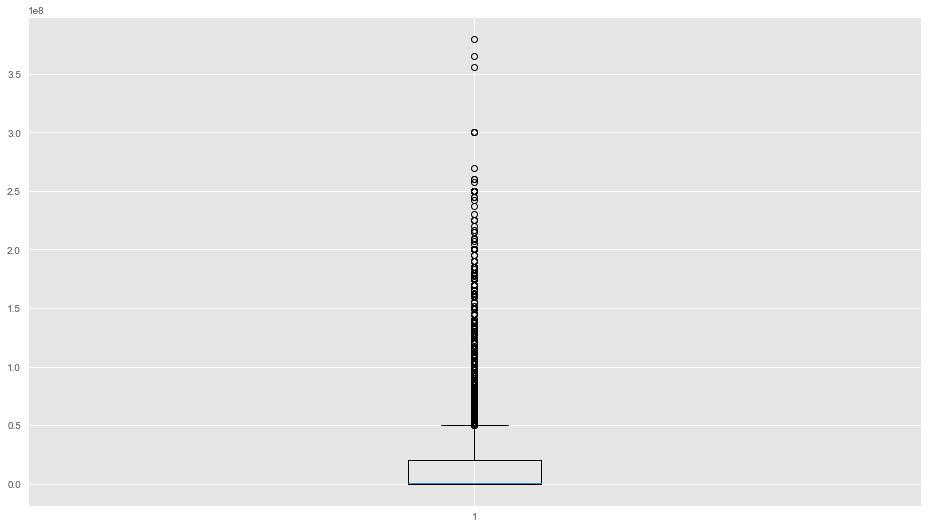

In [5]:
plt.boxplot(datos.budget)
plt.show()

Eliminar datos atípicos

In [6]:
indexes = datos[datos['budget'] < 5e5].index
datos.drop(indexes, inplace=True)

Q1 = datos.budget.quantile(0.25)
Q3 = datos.budget.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['budget'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['budget'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

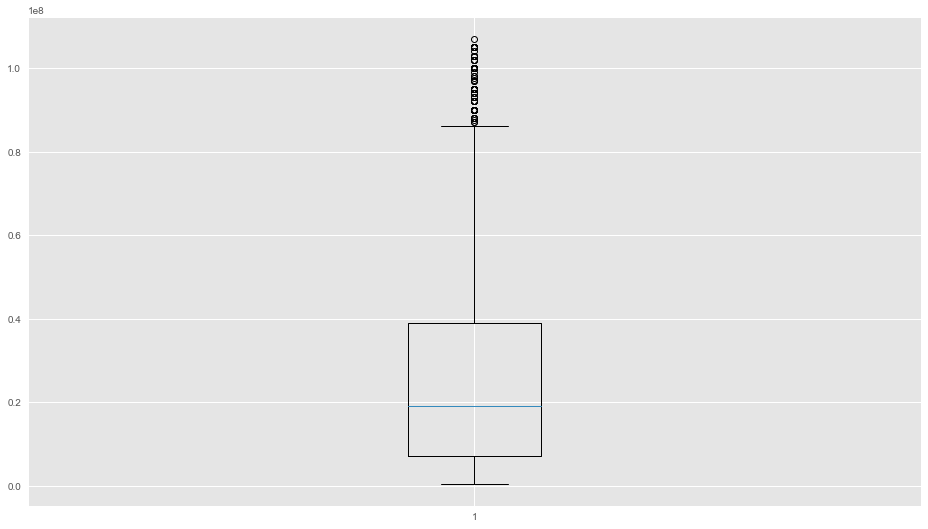

In [7]:
plt.boxplot(datos.budget)
plt.show()

### Análisis de la columna REVENUE

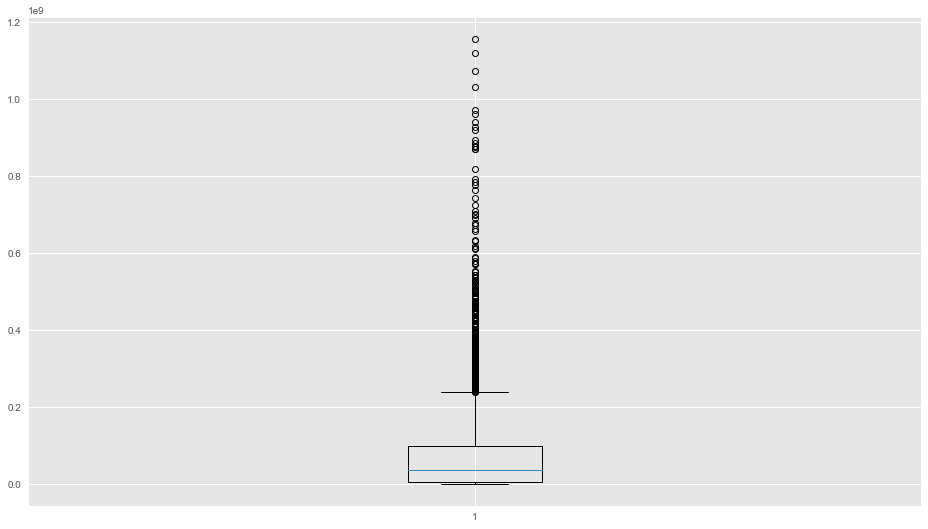

In [8]:
plt.boxplot(datos.revenue)
plt.show()

Eliminar datos atípicos

In [9]:
Q1 = datos.budget.quantile(0.25)
Q3 = datos.budget.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['budget'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['budget'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

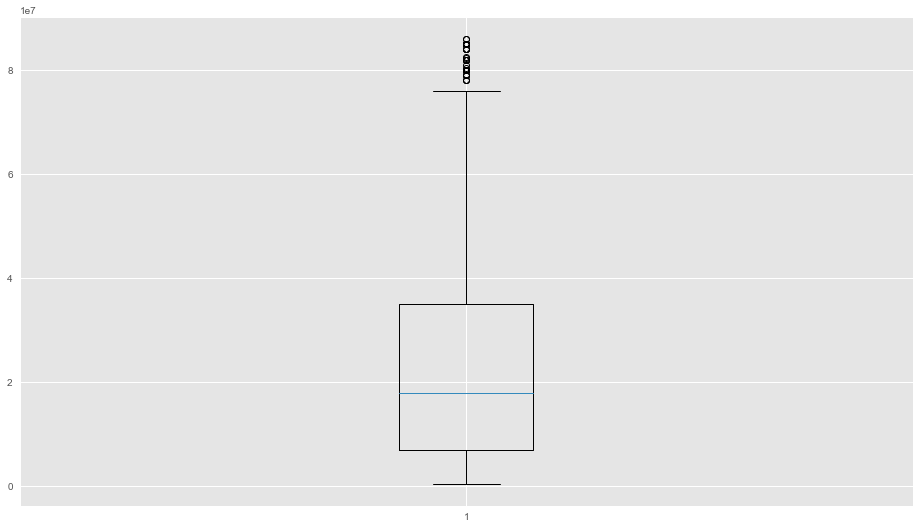

In [10]:
plt.boxplot(datos.budget)
plt.show()

### Análisis de la columna RUNTIME

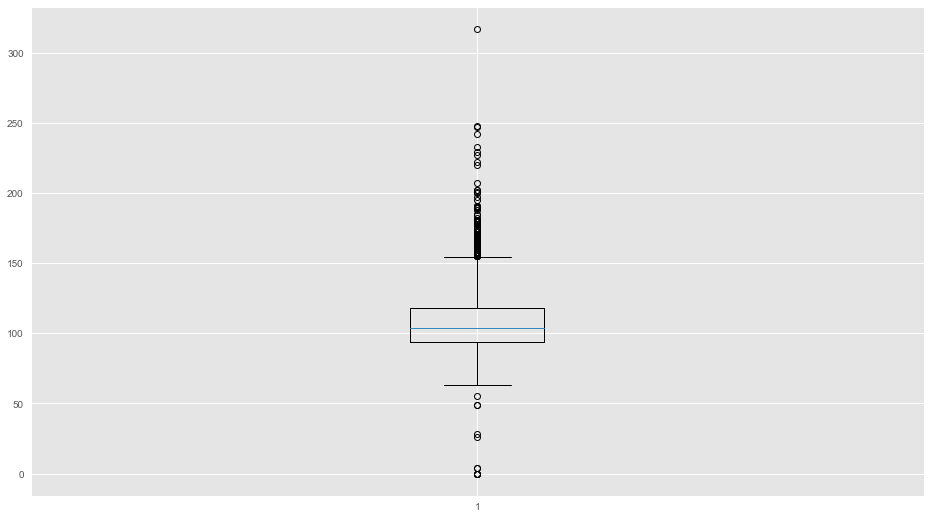

In [11]:
plt.boxplot(datos.runtime)
plt.show()

Eliminar datos atípicos

In [12]:
Q1 = datos.runtime.quantile(0.25)
Q3 = datos.runtime.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['runtime'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['runtime'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

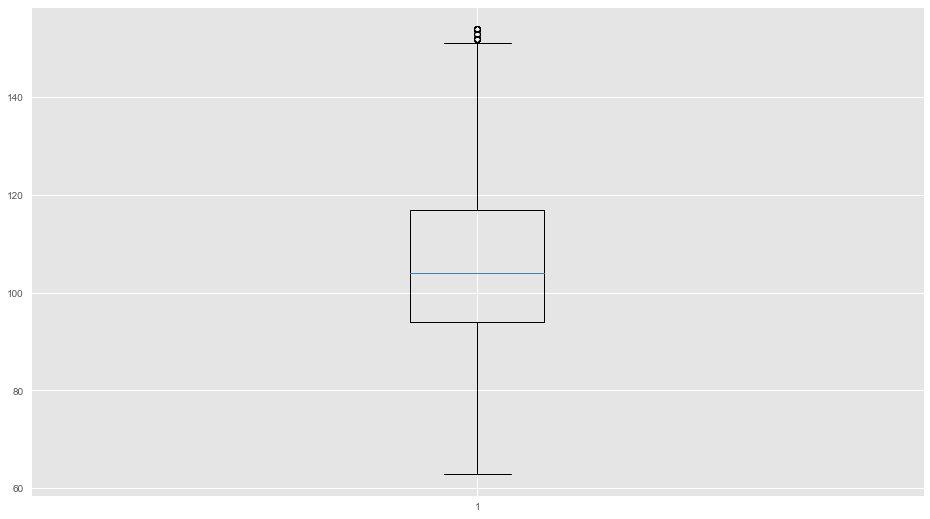

In [13]:
plt.boxplot(datos.runtime)
plt.show()

### Análisis de la columna POPULARITY

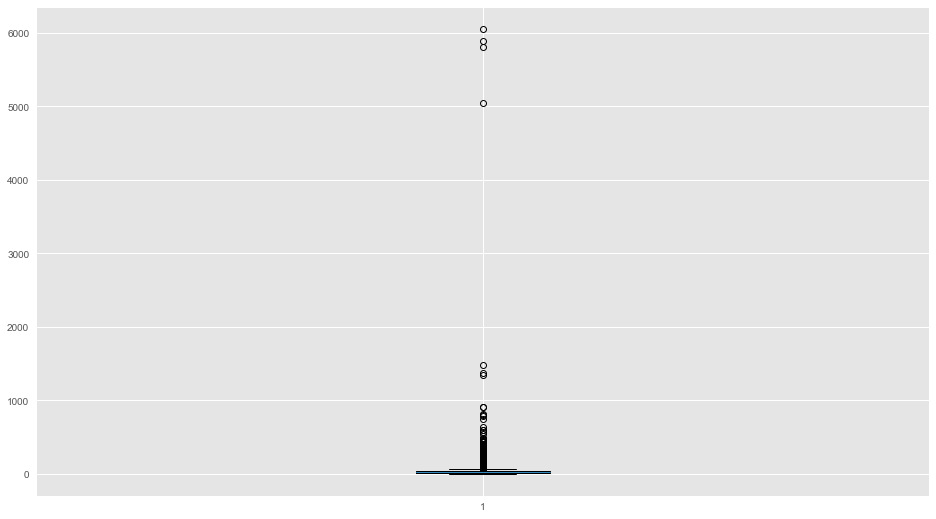

In [14]:
plt.boxplot(datos.popularity)
plt.show()

Eliminar datos atípicos

In [15]:
Q1 = datos.popularity.quantile(0.25)
Q3 = datos.popularity.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['popularity'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['popularity'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

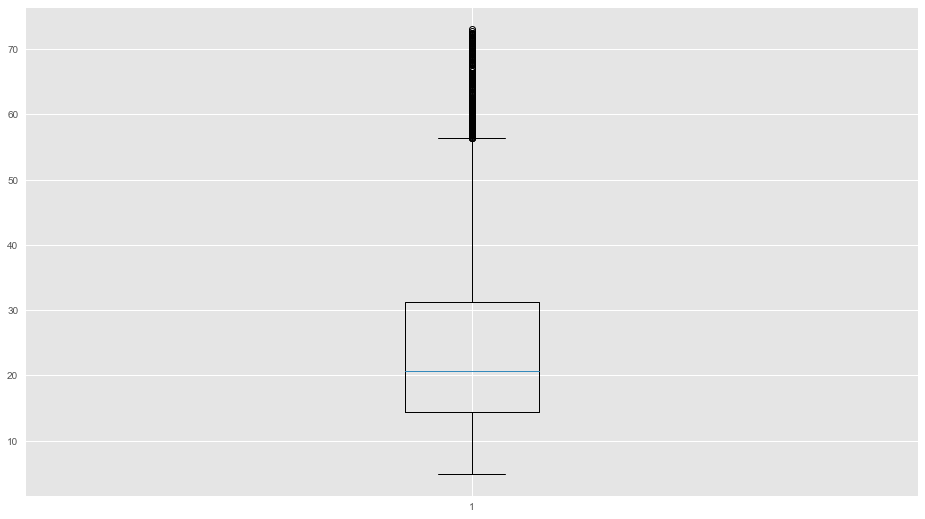

In [16]:
plt.boxplot(datos.popularity)
plt.show()

### Análisis de la columna VOTEAVG

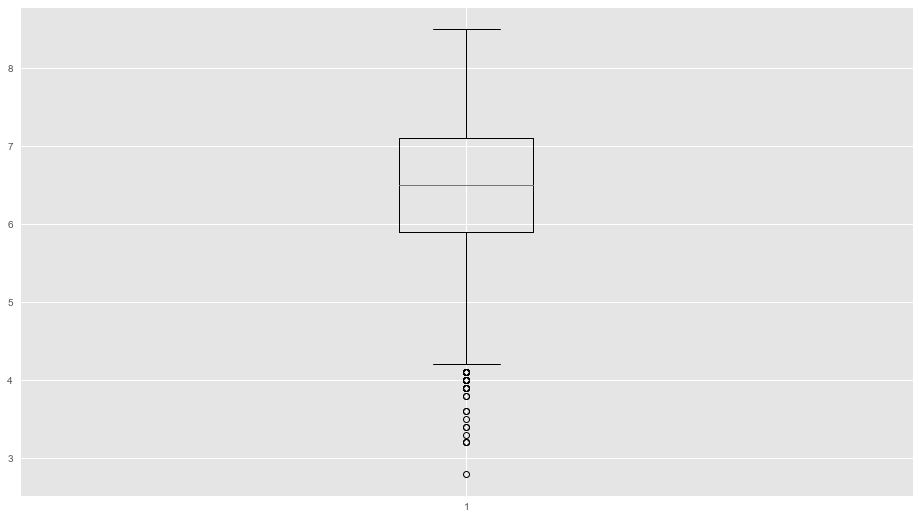

In [17]:
plt.boxplot(datos.voteAvg)
plt.show()

Eliminar datos atípicos

In [18]:
Q1 = datos.voteAvg.quantile(0.25)
Q3 = datos.voteAvg.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['voteAvg'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['voteAvg'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

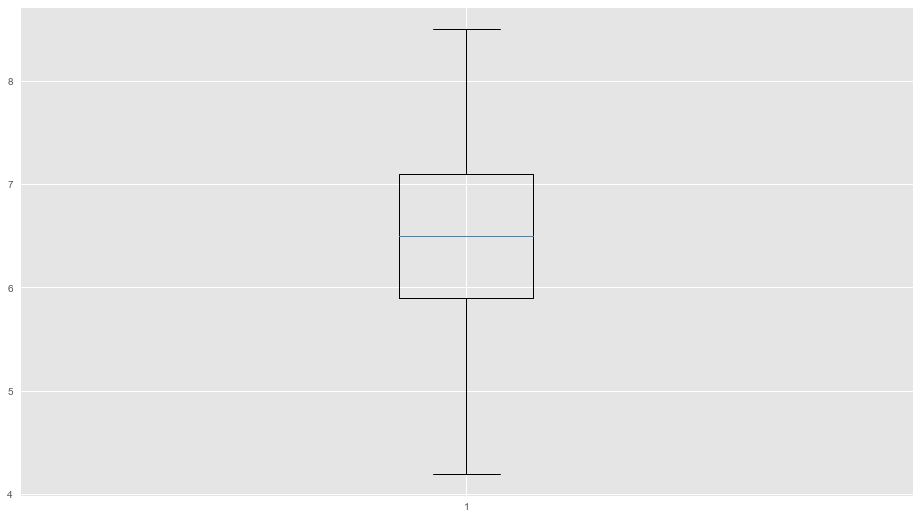

In [19]:
plt.boxplot(datos.voteAvg)
plt.show()

### Análisis de la columna VOTECOUNT

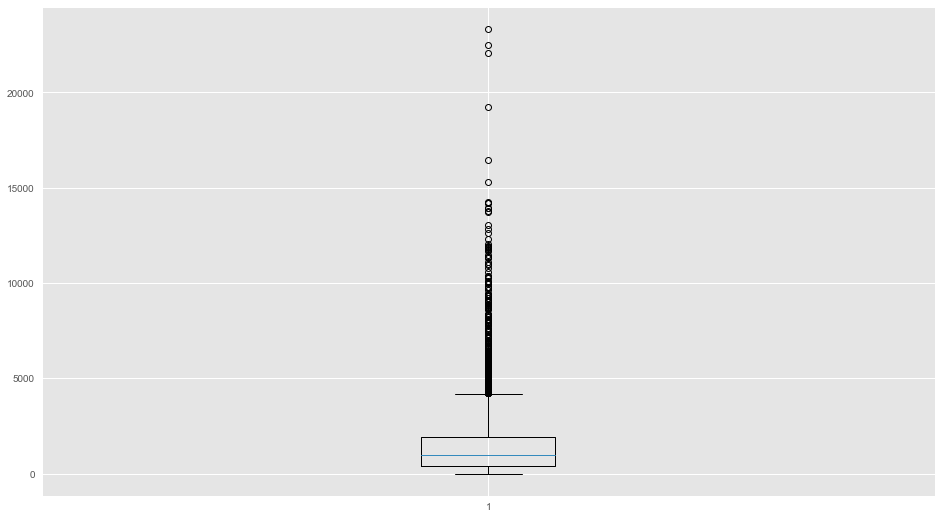

In [20]:
plt.boxplot(datos.voteCount)
plt.show()

Eliminar datos atípicos

In [21]:
Q1 = datos.voteCount.quantile(0.25)
Q3 = datos.voteCount.quantile(0.75)
IQR = Q3 - Q1

indexes = datos[datos['voteCount'] < (Q1 - 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

indexes = datos[datos['voteCount'] > (Q3 + 1.5 * IQR)].index
datos.drop(indexes, inplace=True)

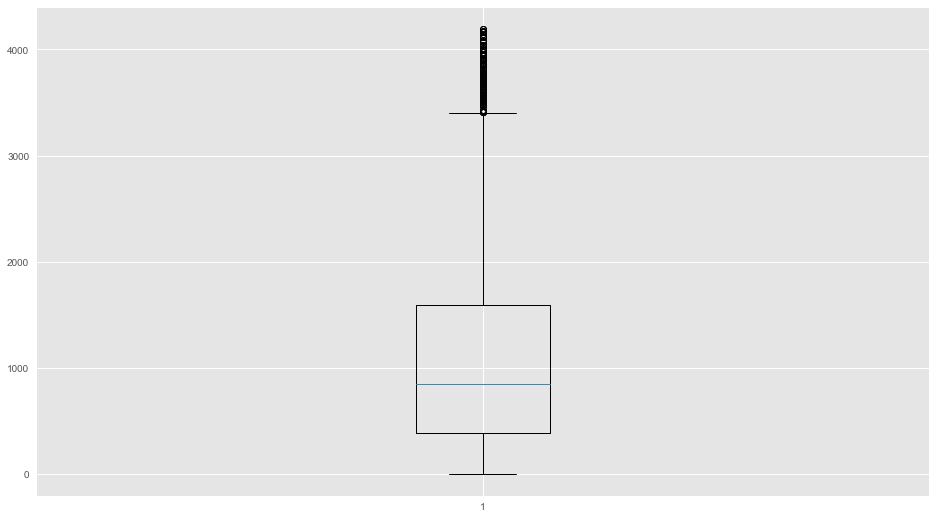

In [22]:
plt.boxplot(datos.voteCount)
plt.show()

### Muestra representativa de la población

In [23]:
sample = datos.copy()

sample["combined"] = list(
    zip(
        sample["budget"],
        sample["revenue"],
        sample["runtime"],
        sample["popularity"],
        sample["voteAvg"],
        sample["voteCount"]
    )
)

combined_weight = sample['combined'].value_counts(normalize=True)

sample['combined_weight'] = sample['combined'].apply(lambda x: combined_weight[x])

sample = sample.sample(25, weights=sample['combined_weight'])
sample = sample.drop(["combined_weight"], axis=1)

sample.describe()

,budget,revenue,runtime,popularity,voteAvg,voteCount
count,2.500000e+01,2.500000e+01,25.000000,25.000000,25.000000,25.000000
mean,2.610000e+07,6.811902e+07,109.480000,22.865840,6.476000,1275.800000
std,2.073493e+07,1.030783e+08,17.342434,10.640177,0.650179,1004.485026
min,3.000000e+06,0.000000e+00,83.000000,10.557000,5.400000,130.000000
25%,1.300000e+07,5.343820e+06,98.000000,17.761000,5.800000,640.000000
50%,1.900000e+07,3.731167e+07,104.000000,20.475000,6.500000,953.000000
75%,3.500000e+07,6.084571e+07,123.000000,24.250000,7.000000,1651.000000
max,8.000000e+07,4.110067e+08,154.000000,61.586000,7.400000,3564.000000


### Correlación de las variables

<AxesSubplot:>

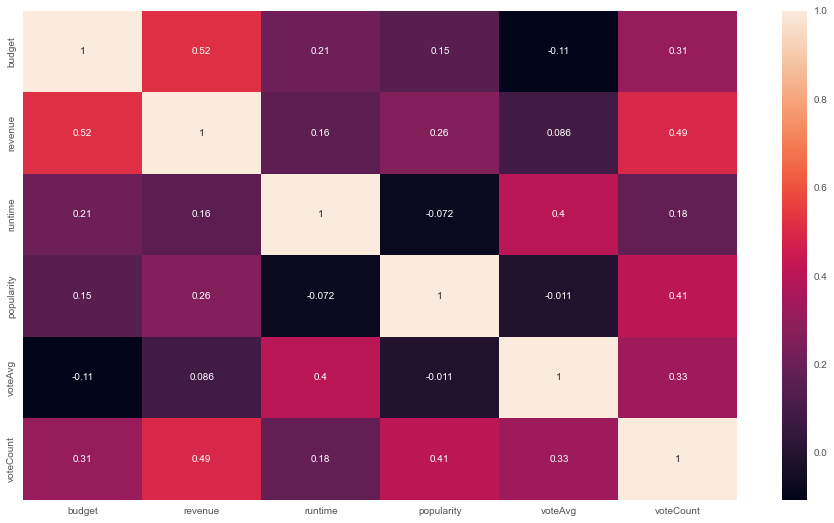

In [24]:
correlacion = datos.corr()
fig, axis = plt.subplots()
sb.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

<AxesSubplot:>

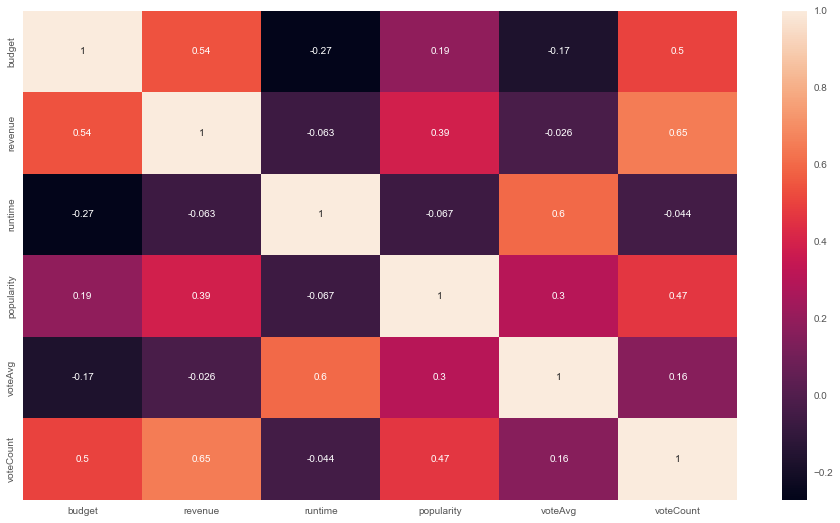

In [25]:
correlacion = sample.corr()
fig, axis = plt.subplots()
sb.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

#### Correlaciones más relevantes

- **Budget:** revenue
- **Revenue:** budget, voteCount
- **Runtime:** voteAvg
- **Popularity:** voteCount
- **VoteAvg:** runtime, voteCount
- **VoteCount:** revenue, popularity, voteAvg

## 2) Tendencia al agrupamiento

### Evaluación de posibles agrupamientos con Estadístico de Hopkings y VAT

#### VoteAvg, VoteCount

In [26]:
votes = datos[["voteAvg", "voteCount"]]

pyclustertend.hopkins(votes,len(votes))

0.32950961767462433

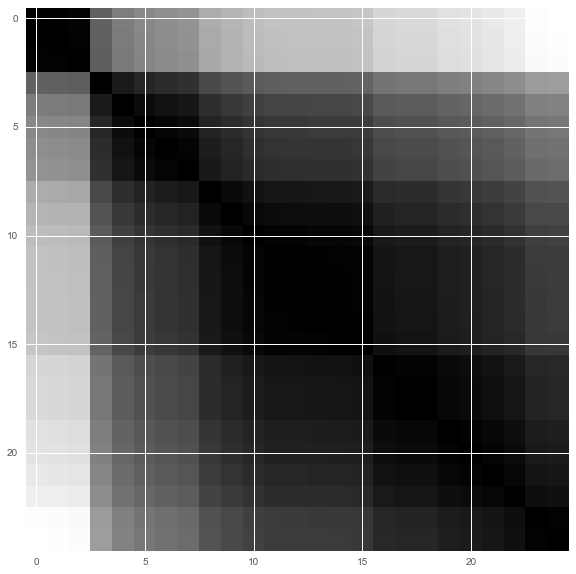

In [27]:
votes = sample[["voteAvg", "voteCount"]]

pyclustertend.vat(votes)

#### VoteAvg, VoteCount, Runtime

In [28]:
votes_runtime = datos[["voteAvg", "voteCount", "runtime"]]

pyclustertend.hopkins(votes_runtime,len(votes_runtime))

0.30222647207123365

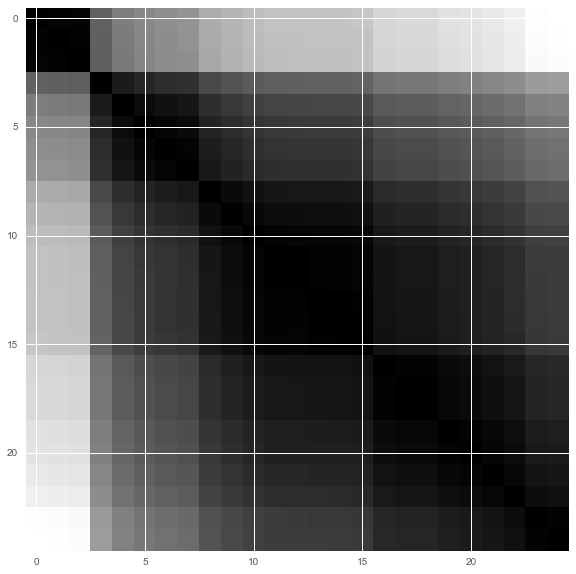

In [29]:
votes_runtime = sample[["voteAvg", "voteCount", "runtime"]]

pyclustertend.vat(votes_runtime)

#### Popularity, voteCount

In [30]:
popularity_votecount = datos[["popularity", "voteCount"]]

pyclustertend.hopkins(popularity_votecount,len(popularity_votecount))

0.2996536449106704

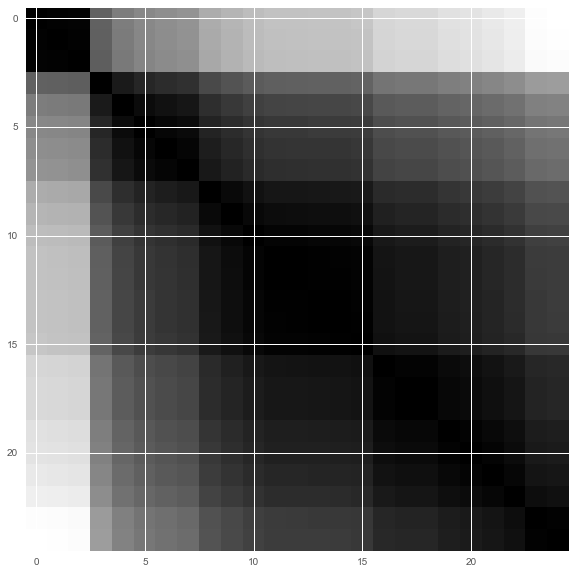

In [31]:
popularity_votecount = sample[["popularity", "voteCount"]]

pyclustertend.vat(popularity_votecount)

#### VoteCount, VoteAvg, Popularity

In [32]:
votes_popularity = datos[["voteCount", "voteAvg", "popularity"]]

pyclustertend.hopkins(votes_popularity,len(votes_popularity))

0.310358088664356

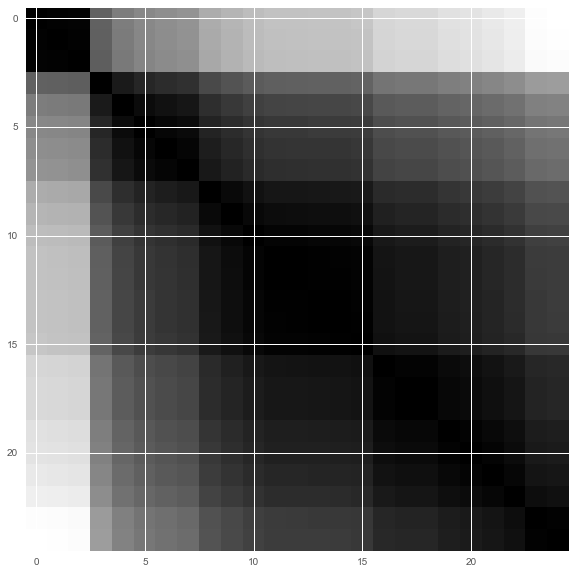

In [36]:
votes_popularity = sample[["voteCount", "voteAvg", "popularity"]]

pyclustertend.vat(votes_popularity)

#### Budget, revenue

In [34]:
budget_revenue = datos[["budget", "revenue"]]

pyclustertend.hopkins(budget_revenue,len(budget_revenue))

0.039043570716954995

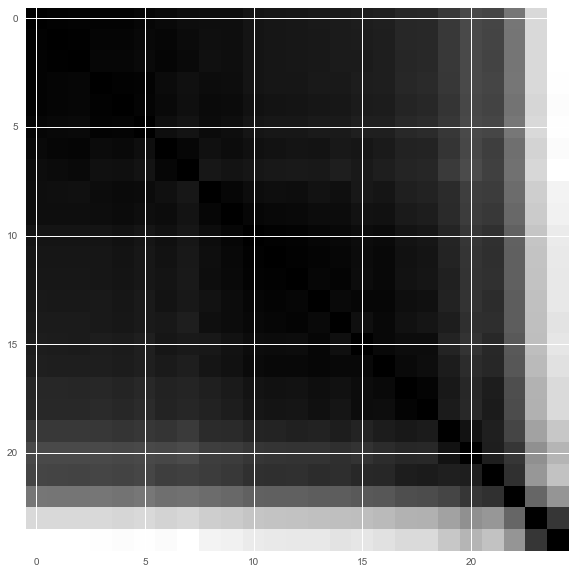

In [35]:
budget_revenue = sample[["budget", "revenue"]]

pyclustertend.vat(budget_revenue)

##  3) Determinación  de  la  cantidad  de  grupos
Esto se realizará por medio de un analisis a las graficas de codo

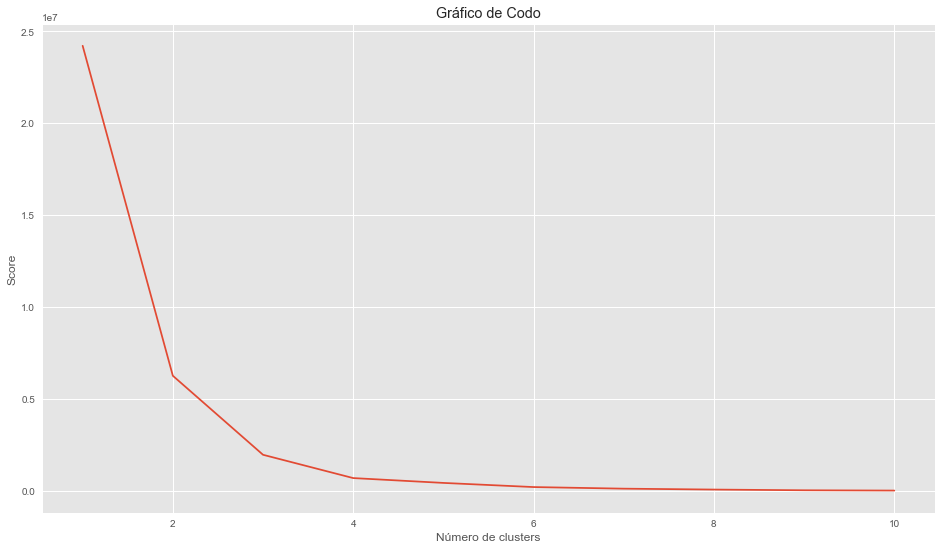

In [37]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(votes)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

Numero indicado de clusters: K = 3

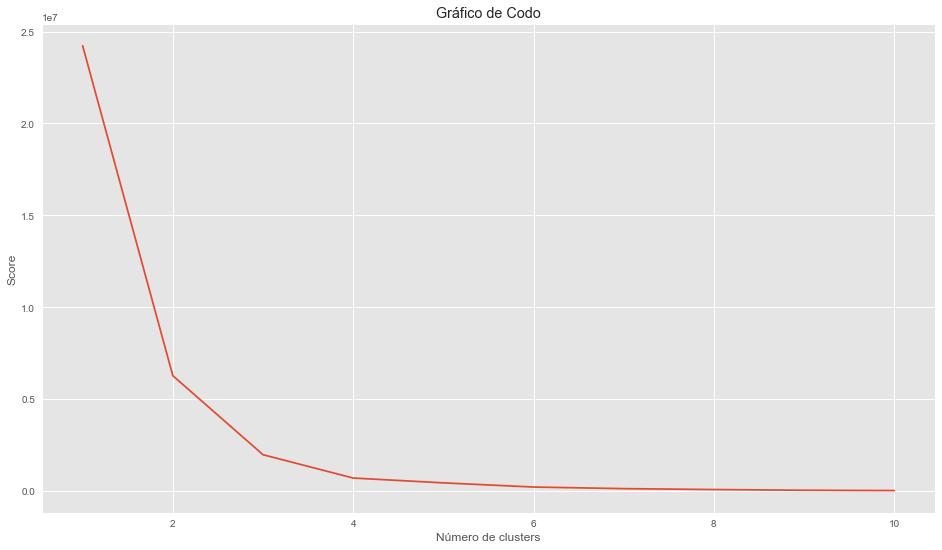

In [38]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(votes_runtime)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

Numero indicado de clusters: K = 3

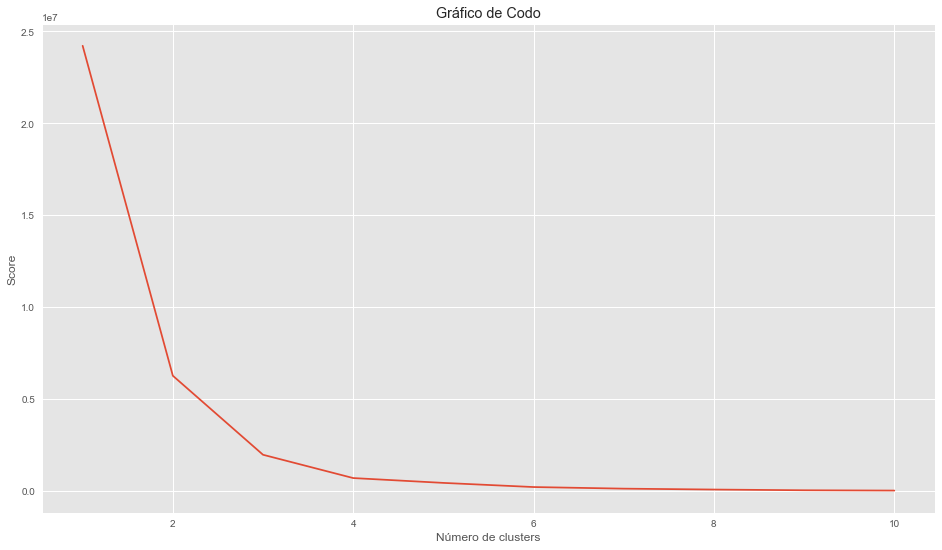

In [39]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(popularity_votecount)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

Numero indicado de clusters: K = 3

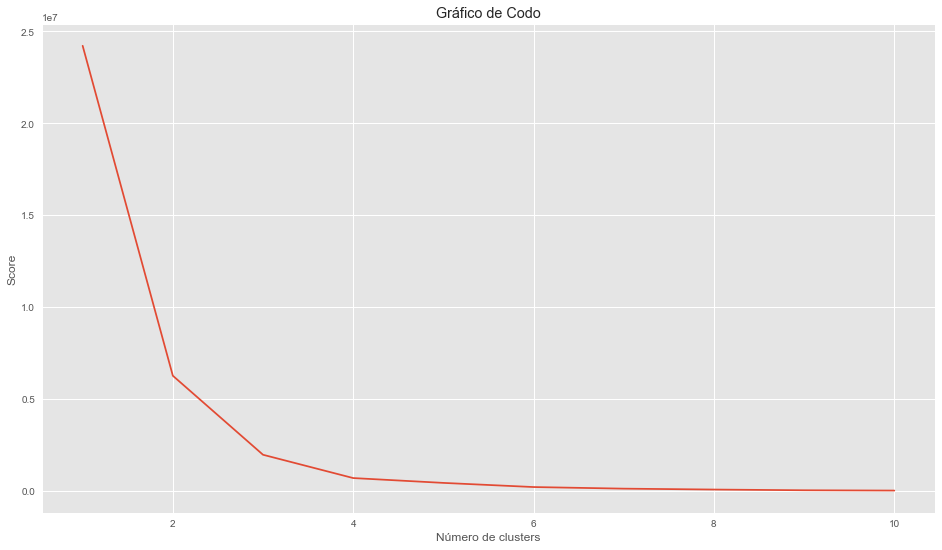

In [40]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(votes_popularity)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

Numero indicado de clusters: K = 3

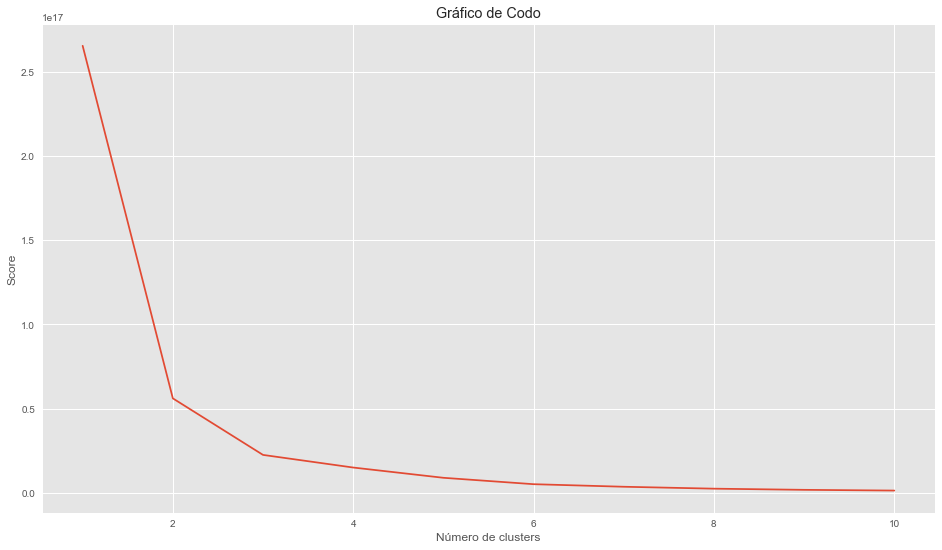

In [41]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(budget_revenue)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()

Numero indicado de clusters: K = 3

## 4) Utilice 3 algoritmos existentes para agrupamiento. Compare los resultados generados por cada uno

Algoritmos a utilizar K-medias, Agrupación Gaussiana, Cluster Jerarquico
para el agrupamiento de voteCount y voteAvg

### K-medias

In [42]:
kmeans = cluster.KMeans(n_clusters = 3)
X = datos.iloc[:, [4, 5]].values
y_kmeans = kmeans.fit_predict(X)

In [43]:
centroides = kmeans.cluster_centers_
print(centroides)

[[   6.54667258 1410.67701863]
 [   6.17480315  431.90341207]
 [   6.82893309 2932.73598553]]


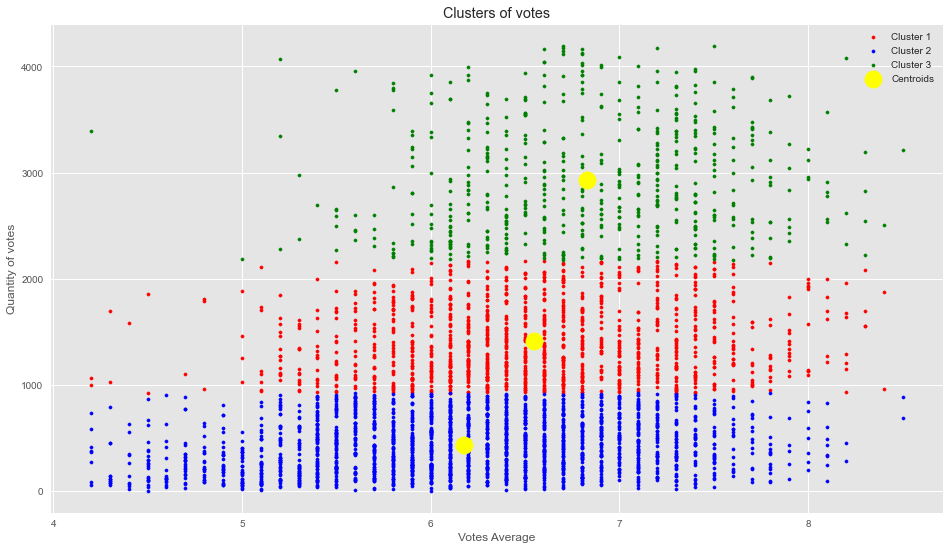

In [44]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of votes')
plt.ylabel('Quantity of votes')
plt.xlabel('Votes Average')
plt.legend()
plt.show()

### Mezcla Gaussiana

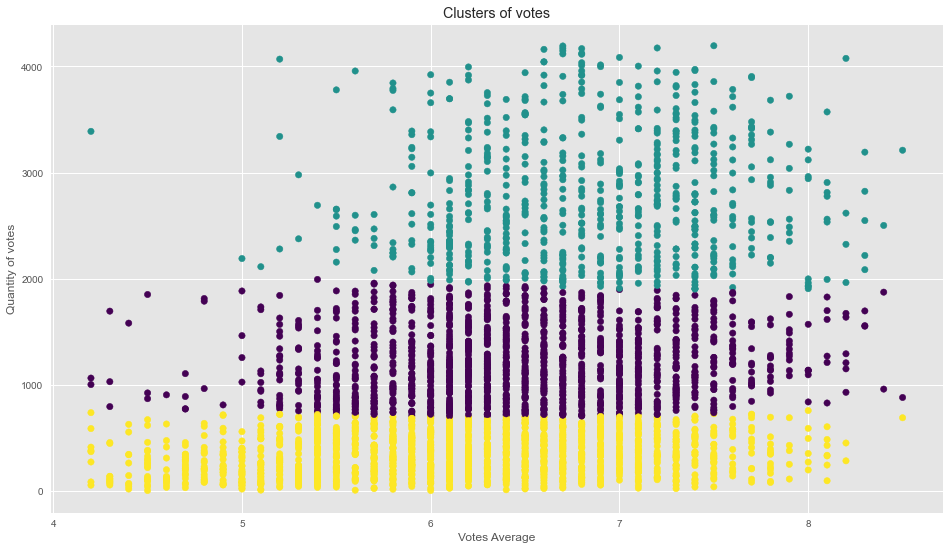

In [45]:
gmm = mixture.GaussianMixture(n_components = 3).fit(X)
labels = gmm.predict(X)
labels
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40,cmap="viridis");
plt.title('Clusters of votes')
plt.ylabel('Quantity of votes')
plt.xlabel('Votes Average')
plt.show()

### Cluster Jerárquico

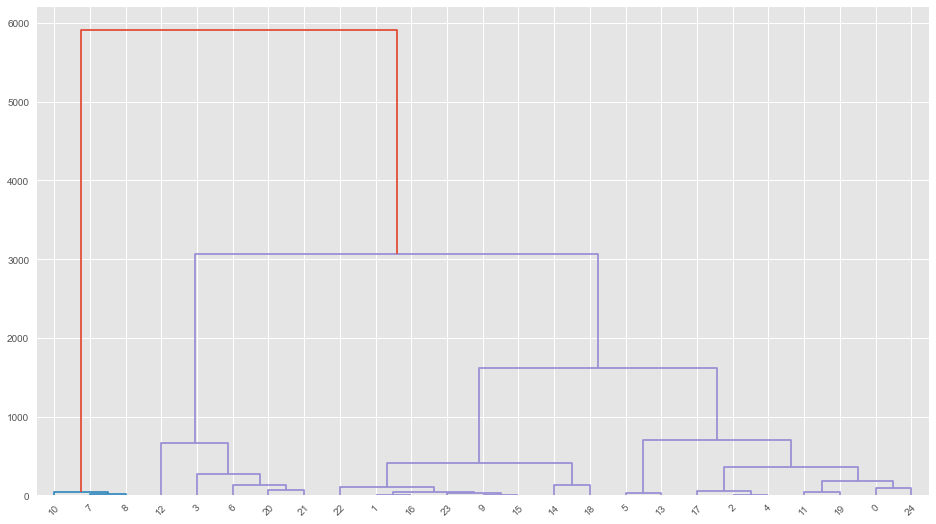

In [46]:
dendograma = sch.dendrogram(sch.linkage(votes, method='ward'))

In [47]:
hc = cluster.AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward')
votesHC = hc.fit_predict(X)
print(votesHC)
print(votes)

[0 1 2 ... 1 1 1]
      voteAvg  voteCount
1966      5.8        346
2502      6.3        958
2372      5.6        640
1571      5.6       1882
2253      5.6        640
855       6.9        162
477       6.5       1731
1225      6.5       3564
5727      6.5       3544
8682      7.4        930
512       7.3       3516
6332      5.4        504
326       6.6       2243
8158      6.8        130
2619      6.2       1128
909       7.3        937
3969      5.8        953
6618      5.4        685
4009      7.1       1256
2213      7.0        545
3432      6.9       1651
1247      6.6       1585
7591      7.0       1019
6836      6.4        908
3831      7.4        438


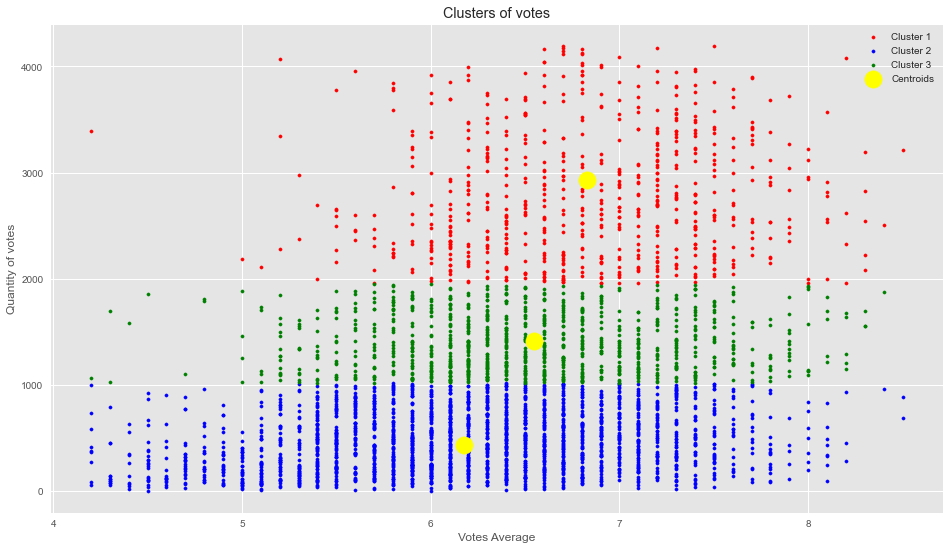

In [48]:
plt.scatter(X[votesHC == 0, 0], X[votesHC == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(X[votesHC == 1, 0], X[votesHC == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(X[votesHC == 2, 0], X[votesHC == 2, 1], s = 10, c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of votes')
plt.ylabel('Quantity of votes')
plt.xlabel('Votes Average')
plt.legend()
plt.show()

### R// Obsevando los diagramas de dispersión de los 3 algoritmos de agrupamiento en el grupo de [voteCount, voteAvg] se puede observar que los 3 son bastante similares en la forma que tienen pero cabe reaclcar que existen diferencias entre ellos.

#### Observaciones
K medias
- El primer grupo esta cerca de los 1000 votos.
- El segundo grupo sobrepasa los 2000 votos, igual que el cluster jerarquico.
- Tiene mucho más puntos "atipicos" que los demas algoritmos.

Mezcla Gaussiana
- El primer grupo termina por 800 votos aproximadamente.
- El segundo grupo no pasa los 2000 votos
- Demuestra más agrupamiento o aproximación entre valores.

Cluster Jerárquico
- El primer grupo si se eencuentra en los 1000 votos exactos.
- Es parecido a la gráfica de K-medias

#### Conclusión: Se puede ver que los 3 algoritmos fueron eficientes a la hora de realizar el agrupamiento de datos. A la hora de una predicción o toma de valor en el analisis de los datos, lo mejor es enfocarse en el grupo de mayor cantidad (3er grupo en las 3 graficas) para obtener los datos mejor valorados y que posiblemente indiquen la verdadera valoración de la pelicula.

## 5) Determine la calidad del agrupamiento hecho por cada algoritmo con el método de la silueta. Discuta los resultados. 

In [49]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

kmedias_score = silhouette_score(X, y_kmeans)
gauss_score = silhouette_score(X, labels)
jerarquico_score = silhouette_score(X, votesHC)

print("Valoración del agrupamiento de K_medias: ", kmedias_score)
print("Valoración del agrupamiento de la mezcla Gaussiana: ",gauss_score)
print("Valoración del agrupamiento del Cluster jerárquico: ",jerarquico_score)

Valoración del agrupamiento de K_medias:  0.6061794714558577
Valoración del agrupamiento de la mezcla Gaussiana:  0.5857646651442058
Valoración del agrupamiento del Cluster jerárquico:  0.5820921780266501


#### Como podemos observar, la mejor valoa

C:\Users\Jose\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


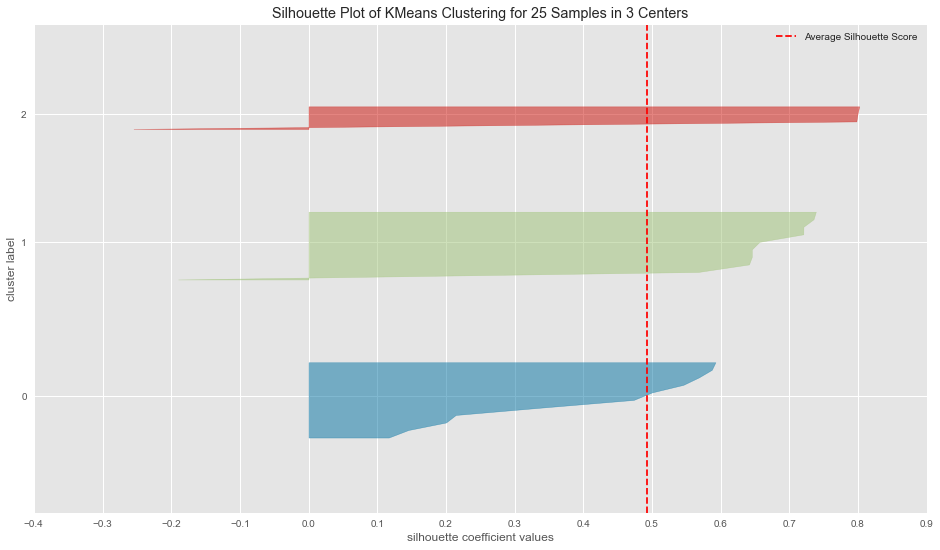

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 25 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
# Instantiate the clustering model and visualizer
model = kmeans
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(votes)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Como se puede ver en la gráfica de siluetas, el indice se encuentra arriba de 0 indicando que la elección del número de clusters fue correcto.

## 6) Trabajo  que  sigue

Escogimos analizar el conjunto de datos de voteAvg y voteCount dado a que es el conjunto donde se obtuvo el mejor valor de Hopkins del resto. Además, la matriz de correlación nos indica que existe una fuerte relación entre estas dos. Por ejemplo, en la primera grafica de K-Medias se puede ver que existe una mayor concentración en el primer grupo en la parte superior, dando a entender que estas peliculas son mas recomendables o no dado a que el promedio fue calculado por una gran cantidad de votos.